<h1> Sign Language Neural Network </h1>
<p>by Robert Kulesza</p>

## Dataset
* Sign Language MNIST dataset
* https://www.kaggle.com/datamunge/sign-language-mnist#sign_mnist_test.zip

## Methods
* <b>Preprocessing</b>
    * batch processing
* <b>Machine Learning Techniques</b>
    * Neural Network
* <b>Results</b>
    * loss
    * accuracy

### import libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn import svm
from sklearn.model_selection import learning_curve

import numpy as np
import random

import os
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd

from sklearn.preprocessing import LabelEncoder

### Load Data

* paths for training and testing data.
* list of csv files in the training / testing directories.
* separated data and labels
* reshaped data to 28*28

In [28]:
CLASSES = [chr(x) for x in range(65,91)]
print(CLASSES)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [2]:
csv_train = "../input/sign-mnist/sign_mnist_train.csv"
csv_test =  "../input/sign-mnist/sign_mnist_test.csv"

In [3]:
df_train = pd.read_csv(csv_train)
df_test = pd.read_csv(csv_test)

array_train_X = np.array(df_train.drop("label",1))
array_train_y = np.array(df_train['label'])

array_test_X = np.array(df_test.drop("label",1))
array_test_y = np.array(df_test['label'])

In [4]:
array_train_X = array_train_X.reshape(len(array_train_X),28,28)
array_test_X = array_test_X.reshape(len(array_test_X),28,28)

### print example image and label

label:  3
AxesImage(54,36;334.8x217.44)


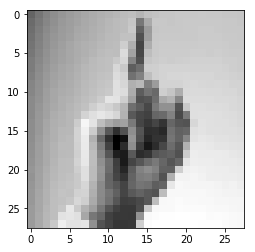

In [5]:
img = array_train_X[0]
lbl = array_train_y[0]

print("label: ",lbl)
print(plt.imshow(img, cmap='gray'))

### Preprocessing

In [6]:
test_batch_size = int(1*len(array_test_X))
train_batch_size = int(1*len(array_train_X))

In [7]:
def preprocess(X,y,batch_size):
    indeces = np.array(list(range(0,len(X))))
    random.shuffle(indeces)
    X, y = np.array([X[indeces[a]] for a in range(0,batch_size)]), np.array([y[indeces[a]] for a in range(0,batch_size)])
    X = X.astype(np.float64) / 100
    X = np.tanh(X) #why isn't this working? -- test single values
    #X = 1/(1 + np.exp(-X)) 
    X = X.reshape(batch_size,28,28,1)
    return X,y

In [8]:
print("test: ",test_batch_size,"/",len(array_test_X))
print("train: ",train_batch_size,"/",len(array_train_X))

print("shape: ",array_train_X.shape)

test:  7172 / 7172
train:  27455 / 27455
shape:  (27455, 28, 28)


In [9]:
array_train_X, array_train_y = preprocess(array_train_X, array_train_y, train_batch_size)
array_test_X, array_test_y = preprocess(array_test_X, array_test_y, test_batch_size)


In [10]:
print("sample of normalized values: \n\n",array_train_X[0][0])

sample of normalized values: 

 [[0.95174596]
 [0.95267884]
 [0.95267884]
 [0.95708542]
 [0.94469516]
 [0.91702576]
 [0.91860189]
 [0.93286155]
 [0.79687814]
 [0.83365461]
 [0.93786303]
 [0.84828364]
 [0.41364444]
 [0.71139373]
 [0.78566386]
 [0.76576202]
 [0.77390834]
 [0.77390834]
 [0.77788807]
 [0.78946122]
 [0.7931991 ]
 [0.80756892]
 [0.83667949]
 [0.86172316]
 [0.87869219]
 [0.89569287]
 [0.90332474]
 [0.90514825]]


### Convolutional Neural Network
**create model**

In [76]:
checkpoint_path = "output/cp.ckpt"

In [75]:
def Create_Model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(400, activation='tanh'))
    model.add(layers.Dense(200, activation='tanh'))
    model.add(layers.Dense(26, activation='softmax'))
    model.summary()
    
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

def train_test_model(model, X_train, y_train, X_test, y_test, checkpoint_path):
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    history = model.fit(X_train, y_train, epochs=13,
                    validation_data=(X_test, y_test), callbacks=[cp_callback])
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    return history


In [64]:
model = Create_Model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 400)              

Train on 27455 samples, validate on 7172 samples
Epoch 1/13
27392/27455 [============================>.] - ETA: 0s - loss: 0.9479 - accuracy: 0.7087
Epoch 00001: saving model to output/cp.ckpt
27455/27455 [==============================] - 18s 638us/sample - loss: 0.9460 - accuracy: 0.7093 - val_loss: 0.5421 - val_accuracy: 0.8259
Epoch 2/13
27424/27455 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9927
Epoch 00002: saving model to output/cp.ckpt
27455/27455 [==============================] - 17s 635us/sample - loss: 0.0492 - accuracy: 0.9927 - val_loss: 0.4347 - val_accuracy: 0.8857
Epoch 3/13
27392/27455 [============================>.] - ETA: 0s - loss: 0.0361 - accuracy: 0.9907
Epoch 00003: saving model to output/cp.ckpt
27455/27455 [==============================] - 17s 618us/sample - loss: 0.0361 - accuracy: 0.9906 - val_loss: 0.5930 - val_accuracy: 0.8501
Epoch 4/13
27392/27455 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9988

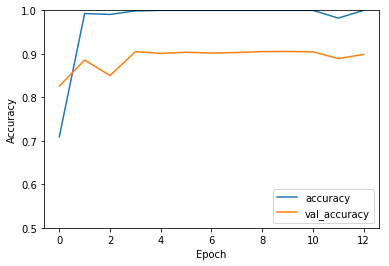

In [65]:
history = train_test_model(model,array_train_X, array_train_y, array_test_X, array_test_y, checkpoint_path)

### Feeding Singular Inputs

In [66]:
class_index = model.predict_classes(array_test_X[0].reshape(1,28,28,1))
clss = CLASSES[class_index[0]]
print(clss)

E


### Load and Save Models


In [72]:
!ls {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [74]:
ld_model = Create_Model()
ld_model.load_weights(checkpoint_path)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 400)              